In [20]:
import pandas as pd

# Load dataset
train_df = pd.read_csv('/content/train_E6oV3lV.csv')

# Display first few rows
train_df.head()


,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [ ]:
# Check for missing values
print(train_df.isnull().sum())

# Fill missing values using different techniques
train_df['tweet'].fillna("No text available", inplace=True)  # Example replacement for missing tweets


In [ ]:
import numpy as np

# Define a function to remove outliers
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Example (if applicable numeric column exists)
# train_df = remove_outliers(train_df, 'column_name')


In [ ]:
from scipy import stats
train_df['tweet_length'] = train_df['tweet'].apply(lambda x: len(x.split()))
train_df = train_df[(np.abs(stats.zscore(train_df['tweet_length'])) < 3)]


In [ ]:
import re

def clean_text(text):
    text = re.sub(r'@\w+', '', text)  # Remove @mentions
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'[^A-Za-z\s]', '', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

train_df['cleaned_tweet'] = train_df['tweet'].apply(clean_text)
train_df.head()


In [ ]:
!pip install -U spacy
!python -m spacy download en_core_web_sm  # Download small English model


In [ ]:
import spacy

# Load English NLP model
nlp = spacy.load("en_core_web_sm")


In [ ]:
import re

def preprocess_text(text):
    # Remove user mentions (@username)
    text = re.sub(r'@\w+', '', text)

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Convert to lowercase
    text = text.lower()

    # Process text with spaCy NLP model
    doc = nlp(text)

    # Lemmatization & Stopword Removal
    processed_tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]

    # Join tokens back into a string
    return " ".join(processed_tokens)

# Example usage
sample_text = "@user This is an example of #hate speech detection using spaCy! Visit http://example.com"
processed_text = preprocess_text(sample_text)
print(processed_text)


In [25]:
train_df['processed_tweet'] = train_df['tweet'].apply(preprocess_text)
train_df.head()


,id,label,tweet,processed_tweet
0,1,0,@user when a father is dysfunctional and is s...,father dysfunctional selfish drag kid dysfunct...
1,2,0,@user @user thanks for #lyft credit i can't us...,thank lyft credit use cause offer wheelchair v...
2,3,0,bihday your majesty,bihday majesty
3,4,0,#model i love u take with u all the time in ...,model love u u time
4,5,0,factsguide: society now #motivation,factsguide society motivation


In [ ]:
train_df.to_csv('/content/processed_train.csv', index=False)


In [ ]:
train_df['label'].value_counts(normalize=True)


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_tfidf = tfidf_vectorizer.fit_transform(train_df['processed_tweet'])


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer(max_features=5000, stop_words='english')
X_count = count_vectorizer.fit_transform(train_df['processed_tweet'])


In [ ]:
print("TF-IDF Shape:", X_tfidf.shape)
print("CountVectorizer Shape:", X_count.shape)

In [ ]:
import gensim
from gensim.models import Word2Vec

# Tokenize sentences for Word2Vec
sentences = [tweet.split() for tweet in train_df['processed_tweet']]

# Train Word2Vec model
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=2, workers=4)

# Convert tweets into embeddings (average word vectors per sentence)
def get_avg_word2vec(tokens, model):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    return sum(vectors) / len(vectors) if vectors else np.zeros(model.vector_size)

# Apply Word2Vec embeddings
train_df['word2vec_features'] = train_df['processed_tweet'].apply(lambda x: get_avg_word2vec(x.split(), word2vec_model))

Model Building & Training

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split

# Tokenization
tokenizer = Tokenizer(num_words=5000)  # Limit vocabulary to 5000 words
tokenizer.fit_on_texts(train_df['processed_tweet'])
X_seq = tokenizer.texts_to_sequences(train_df['processed_tweet'])

# Padding sequences to make them of equal length
X_padded = pad_sequences(X_seq, maxlen=100)  # Choose max length

# Prepare labels
y = train_df['label']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)

# Build LSTM Model
model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=100),
    SpatialDropout1D(0.2),
    LSTM(100, dropout=0.2, recurrent_dropout=0.2),
    Dense(1, activation='sigmoid')
])

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train model
model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))

# Evaluate model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"LSTM Model Accuracy: {accuracy:.4f}")

In [17]:
from tensorflow.keras.layers import Bidirectional

# Build BiLSTM Model
model_bilstm = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=100),
    SpatialDropout1D(0.2),
    Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)),
    Dense(1, activation='sigmoid')
])

# Compile model
model_bilstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train model
model_bilstm.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))

# Evaluate model
loss, accuracy = model_bilstm.evaluate(X_test, y_test)
print(f"BiLSTM Model Accuracy: {accuracy:.4f}")

Epoch 1/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 231s 553ms/step - accuracy: 0.9276 - loss: 0.2344 - val_accuracy: 0.9601 - val_loss: 0.1237
Epoch 2/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 266s 564ms/step - accuracy: 0.9676 - loss: 0.0922 - val_accuracy: 0.9618 - val_loss: 0.1184
Epoch 3/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 218s 545ms/step - accuracy: 0.9755 - loss: 0.0725 - val_accuracy: 0.9620 - val_loss: 0.1282
Epoch 4/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 264s 548ms/step - accuracy: 0.9795 - loss: 0.0597 - val_accuracy: 0.9609 - val_loss: 0.1307
Epoch 5/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 263s 552ms/step - accuracy: 0.9838 - loss: 0.0467 - val_accuracy: 0.9631 - val_loss: 0.1417
200/200 ━━━━━━━━━━━━━━━━━━━━ 15s 75ms/step - accuracy: 0.9640 - loss: 0.1329
BiLSTM Model Accuracy: 0.9631


In [18]:
import pickle

with open("nlp_hate_speech_model.pkl", "wb") as model_file:
    pickle.dump(model_bilstm, model_file)  # Save BiLSTM model

In [19]:
def predict_hate_speech(text):
    text_seq = tokenizer.texts_to_sequences([text])
    text_padded = pad_sequences(text_seq, maxlen=100)
    prediction = model_bilstm.predict(text_padded)
    return "Hate Speech" if prediction[0] > 0.5 else "Non-Hate Speech"

print(predict_hate_speech("I hate everything!"))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 957ms/step
Non-Hate Speech


Select & Train Base Model - Logistic Regression (Linear Model)

In [27]:
# Ensure no missing values in labels
train_df = train_df.dropna(subset=['label'])

# Re-run TF-IDF feature extraction (ensure same length)
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_tfidf = tfidf_vectorizer.fit_transform(train_df['processed_tweet'])

# Ensure X_tfidf is properly aligned with train_df['label']
X_tfidf = X_tfidf[:train_df.shape[0]]  # Use shape[0] instead of len()
train_df = train_df.iloc[:X_tfidf.shape[0]]  # Align labels with X_tfidf

print(f"✅ Shape of Features (X_tfidf): {X_tfidf.shape}")
print(f"✅ Shape of Labels (train_df['label']): {train_df['label'].shape}")

✅ Shape of Features (X_tfidf): (31962, 5000)
✅ Shape of Labels (train_df['label']): (31962,)


In [28]:
from sklearn.model_selection import train_test_split

# Split dataset into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, train_df['label'], test_size=0.2, random_state=42)

print(f"Training Set: {X_train.shape}, {y_train.shape}")
print(f"Testing Set: {X_test.shape}, {y_test.shape}")

Training Set: (25569, 5000), (25569,)
Testing Set: (6393, 5000), (6393,)


Train a Linear Model (Logistic Regression)

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Train Logistic Regression model
logreg = LogisticRegression(max_iter=500, random_state=42)
logreg.fit(X_train, y_train)

# Predictions
y_pred_logreg = logreg.predict(X_test)

# Evaluation
print("🔹 Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_logreg))
print("🔹 Classification Report:\n", classification_report(y_test, y_pred_logreg))

🔹 Logistic Regression Accuracy: 0.9510402002189895
🔹 Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97      5937
           1       0.92      0.34      0.50       456

    accuracy                           0.95      6393
   macro avg       0.94      0.67      0.74      6393
weighted avg       0.95      0.95      0.94      6393



Train an Ensemble Model (Random Forest)

In [30]:
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluation
print("🔹 Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("🔹 Classification Report:\n", classification_report(y_test, y_pred_rf))

🔹 Random Forest Accuracy: 0.9587048334115439
🔹 Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      5937
           1       0.81      0.55      0.66       456

    accuracy                           0.96      6393
   macro avg       0.89      0.77      0.82      6393
weighted avg       0.96      0.96      0.96      6393



Train a Boosting Model (XGBoost)

In [31]:
!pip install xgboost  # Install XGBoost if not already installed
from xgboost import XGBClassifier

# Train XGBoost Model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluation
print("🔹 XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("🔹 Classification Report:\n", classification_report(y_test, y_pred_xgb))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:13:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


🔹 XGBoost Accuracy: 0.9526044110746129
🔹 Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.97      5937
           1       0.83      0.43      0.56       456

    accuracy                           0.95      6393
   macro avg       0.89      0.71      0.77      6393
weighted avg       0.95      0.95      0.95      6393



Model Performance Comparison (Dashboard)

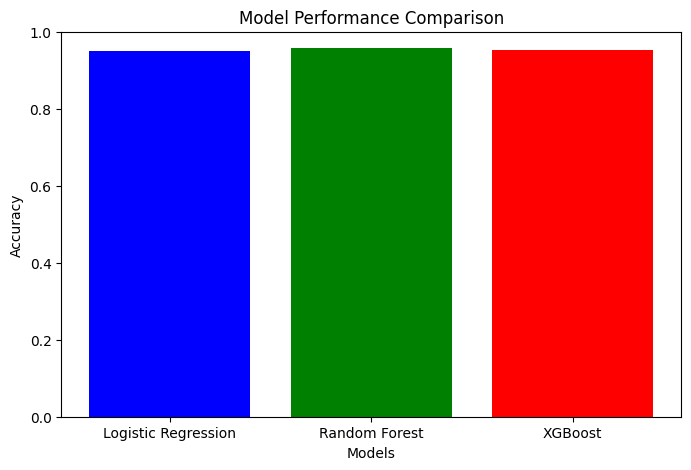

In [32]:
import matplotlib.pyplot as plt

# Model names and accuracy scores
models = ['Logistic Regression', 'Random Forest', 'XGBoost']
accuracies = [
    accuracy_score(y_test, y_pred_logreg),
    accuracy_score(y_test, y_pred_rf),
    accuracy_score(y_test, y_pred_xgb)
]

# Plot bar chart
plt.figure(figsize=(8,5))
plt.bar(models, accuracies, color=['blue', 'green', 'red'])
plt.ylim(0, 1)
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Model Performance Comparison")
plt.show()